### Minimal code to generate data from Ising model
1/2/24 Noah Chavez

In [465]:
# Imports -- no Pygame needed 
import numpy as np
import random
import matplotlib.pyplot as plt
 
# init lattice
def initLattice(latticeSize: int, hot: bool) -> list[list[int]]:
    lattice = np.zeros((latticeSize, latticeSize))
    for x in np.arange(0, latticeSize):
        for y in np.arange(0, latticeSize):
            if hot:
                spin = random.randint(0,1)
            else:
                spin = 1
            if(spin == 1):
                lattice[x][y] = 1
            else:
                lattice[x][y] = -1
    return lattice


# Calculate change in energy of lattice by flipping a single site (i,j)
def deltaU(i: int, j: int, lattice: list) -> float:
    '''
    This calulation requires considering neighboring sites (first term in Hamiltonian)
    Therefore, we will use periodic boundary conditions (torus)
    I would like to imlement the external field term so you can drive the system to specific states

    E1 = -spin(i,j)*sum(spin(neighbors)),     E2 = spin(i,j)*sum(spin(neighbors))
    Ediff = E2 - E1 = 2spin(i,j)*sum(neighbors) (if spin(i,j) is 1 (up))            <<<<< NO epsilon/J? unclear why, currently just implementing pseudocode exactly as written

    In the mean field approximation E_up = -4J*sum(spin(neighbors))/4) 

    i is vertical, j is horizontal, zero indexed
    '''

    size = len(lattice)
    # If site is in an edge, apply periodic boundary conditions
    if(i == 0):
        top = lattice[size-1,j]
    else:
        top = lattice[i-1][j]
    if(i == size-1):
        bottom = lattice[0][j]
    else:
        bottom = lattice[i+1][j]
    if(j == 0):
        left = lattice[i][size-1]
    else:
        left = lattice[i][j-1]
    if(j == size-1):
        right = lattice[i][0]
    else:
        right = lattice[i][j+1]

    #now calculate the energy difference
    Ediff = 2*lattice[i][j]*(top+bottom+left+right)
    return Ediff


# size = 25 #was 50
# siteSize = 10
# lat = initLattice(size,siteSize) #lattice starts at high T (randomized)


AVERAGING = True

def Metropolis(lattice, initTemp, iterations):
    '''
    Metropolis acts on a lattice passed in and does NOT initialize each time. Therefore
    there is no need to wait for thermalization from hot start each time
    '''
    #store m in array
    mArr = np.array([])
    mArrAvg = np.array([])

    for i in range(iterations):
        #in units of J/k (J is epsilon the coupling constant, k is boltzmann k) Tc=2.27
        #calculate magnetization (should this go in just the while True loop?)
        m = 0
        for x in range(lattice[0].size):
            for y in range(lattice[0].size):
                m += lattice[x][y]
                
        m = m / np.power(lattice[0].size,2)
        #print("m: %s" % m)
        # if averaging/smoothing enabled average a batch and add it
        mArr = np.append(mArr,m)
        if(AVERAGING):
            bs = iterations #batch size
            if(mArr.size % bs == 0):
                sum = np.sum(mArr[mArr.size-bs:])
                bAvg = sum/bs
                mArrAvg = np.append(mArrAvg, bAvg)
        
    
        #calc Ediff for a site
        i = random.randint(0,lattice[0].size-1) 
        j = random.randint(0,lattice[0].size-1)
        Ediff = deltaU(i,j,lattice)
        #Metropolis to decide whether site should be flipped. Needs to be iterated 100 times??
        if(Ediff <= 0):
            lattice[i][j] = -lattice[i][j] 
        else:
            #now only flip site according to Boltzmann factor
            boltzmannRandom = random.uniform(0,1)
            if(boltzmannRandom < np.exp(-Ediff/initTemp)):
                lattice[i][j] = -lattice[i][j]

    if(AVERAGING):
        return mArrAvg
    else: 
        return mArr

# #T = 0.01, iters = 40000
# T = 0.01
# iters = 65000
# mArr = Metropolis(lat, T, iters) 


In [163]:
#init lattice
size = 10 #was 50
lat = initLattice(size,False) #lattice starts at high T (randomized)

#Now perform metropolois over a quasi-static temperature sweep 
#T = 0.01, iters = 40000
T = 0.1
iters = 100 #65000 is enough to reach equilibrium from hot start -- it is probably a bit too much 150000

mArr = []

for i in range(80):
    mOut = Metropolis(lat, T, iters)
    mArr = np.append(mArr, mOut)
    T += 0.05




as a function of T

In [153]:
lat = initLattice(size,False)
Metropolis(lat,2.27,10000)

array([0.789638])

as afuncton of step

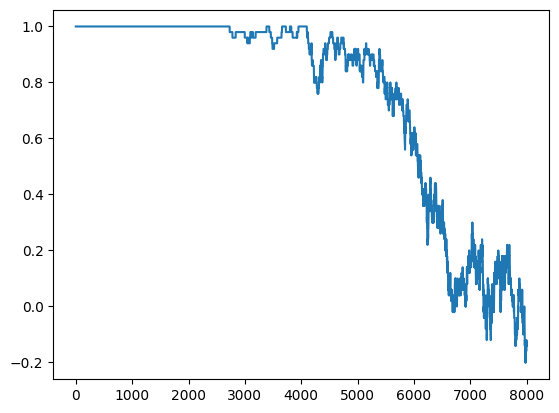

In [102]:
#Now plot the magnitzation as a func of iteration
#eqMPos = np.full((mArrCool.size,1),np.power(size,2))
#eqMNeg = np.full(
# (mArrCool.size,1),-np.power(size,2))
#iterCool = np.arange(0,mArrCool.size)
#plt.plot(iterCool,eqMPos, color="red")
#plt.plot(iterCool,eqMNeg, color="black")
#plt.scatter(iterCool, mArrCool, s=1)
#EOD = max(iterCool)
#iter = np.arange(EOD, EOD + mArr.size)

plt.plot(np.arange(0,mArr.size), mArr)
plt.show()
#plt.savefig("MfuncofStep.png", dpi=300, format="png")

I wonder if finite scaling effects produce metastable states with higher frequency? **It seems that ~40,000 iterations is enough for the system to reach equilibrium** Therefore, a first implementation to keep the system in equilibrium as we change temp is to step temp up, wait 40,000 steps and then step up. 40,000 iterations takes 3.3 seconds.

In [89]:
#Now sweep temperature

#TODO I should probably add a paramter that allows me to control some averaging parameter so i dont spit out ~40k data points PER TEMEP STEP

## Here, I redo the Metropolis, forcing each site to be checked

In [323]:

AVERAGING = True

def MetropolisALL(lattice, initTemp, iterations):
    '''
    Metropolis acts on a lattice passed in and does NOT initialize each time. Therefore
    there is no need to wait for thermalization from hot start each time
    '''
    #store m in array
    mArr = np.array([])
    mArrAvg = np.array([])

    for i in range(iterations):
        #in units of J/k (J is epsilon the coupling constant, k is boltzmann k) Tc=2.27
        #calculate magnetization (should this go in just the while True loop?)
        m = 0
        for x in range(lattice[0].size):
            for y in range(lattice[0].size):
                m += lattice[x][y]
                
        m = m / np.power(lattice[0].size,2)
        #print("m: %s" % m)
        # if averaging/smoothing enabled average a batch and add it
        mArr = np.append(mArr,m)
        if(AVERAGING):
            bs = iterations #batch size
            if(mArr.size % bs == 0):
                sum = np.sum(mArr[mArr.size-bs:])
                bAvg = sum/bs
                mArrAvg = np.append(mArrAvg, bAvg)
        
    
        #calc Ediff for ALL sites
        for i in range(lattice[0].size):
            for j in range(lattice[0].size):
                Ediff = deltaU(i,j,lattice)
                #Metropolis to decide whether site should be flipped. Needs to be iterated 100 times??
                if(Ediff <= 0):
                    lattice[i][j] = -lattice[i][j] 
                else:
                    #now only flip site according to Boltzmann factor
                    boltzmannRandom = random.uniform(0,1)
                    if(boltzmannRandom < np.exp(-Ediff/initTemp)):
                        lattice[i][j] = -lattice[i][j]

    if(AVERAGING):
        return mArrAvg
    else: 
        return mArr



In [ ]:
#init lattice
size = 10 #was 50
lat = initLattice(size,False) #lattice starts at high T (randomized)

#Now perform metropolois over a quasi-static temperature sweep 
#T = 0.01, iters = 40000
T = 0.1

mPlot = []

for j in range(50):
    print("j: %s" %j)
    mOut = []
    for i in np.arange(0,100):
        mOut.append(MetropolisALL(lat, T, 100*size*size))
        
    avg = sum(mOut)/len(mOut)
    mPlot = np.append(mPlot, avg)
    T += 0.05
    print("T: %s" % T)

#print(sum(mPlot)/mPlot.size)

j: 0
T: 10.05
j: 1
T: 10.100000000000001
j: 2
T: 10.150000000000002
j: 3
T: 10.200000000000003
j: 4
T: 10.250000000000004
j: 5
T: 10.300000000000004
j: 6
T: 10.350000000000005
j: 7
T: 10.400000000000006
j: 8
T: 10.450000000000006
j: 9
T: 10.500000000000007
j: 10
T: 10.550000000000008
j: 11
T: 10.600000000000009
j: 12
T: 10.65000000000001
j: 13
T: 10.70000000000001
j: 14
T: 10.75000000000001
j: 15
T: 10.800000000000011
j: 16
T: 10.850000000000012
j: 17
T: 10.900000000000013
j: 18
T: 10.950000000000014
j: 19
T: 11.000000000000014
j: 20
T: 11.050000000000015
j: 21
T: 11.100000000000016
j: 22
T: 11.150000000000016
j: 23
T: 11.200000000000017
j: 24
T: 11.250000000000018
j: 25
T: 11.300000000000018
j: 26
T: 11.35000000000002
j: 27
T: 11.40000000000002
j: 28
T: 11.45000000000002
j: 29
T: 11.500000000000021
j: 30
T: 11.550000000000022
j: 31
T: 11.600000000000023
j: 32
T: 11.650000000000023
j: 33
T: 11.700000000000024
j: 34
T: 11.750000000000025
j: 35
T: 11.800000000000026
j: 36
T: 11.850000000

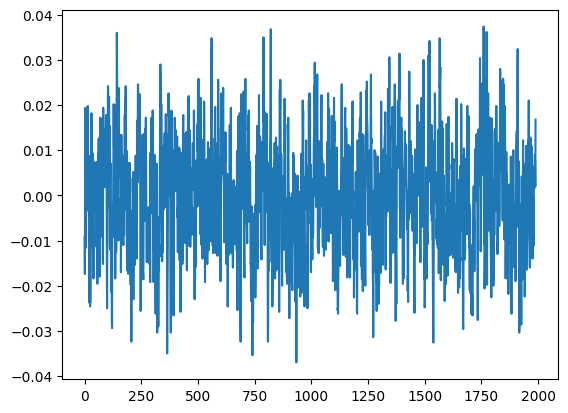

In [674]:
plt.plot(np.arange(0,mPlot.size), mPlot)

# auto = []
# for i in np.arange(0,mPlot.size):
#     auto.append(mlAC(mPlot,i))
# plt.plot(np.arange(0,mPlot.size), auto)

#plt.xlim(0,10000)
plt.show()
#plt.savefig("MfuncofStep134min.png", dpi=300, format="png")

In [613]:

def MetropolisALL(lattice, initTemp, iterations):
    '''
    Metropolis acts on a lattice passed in and does NOT initialize each time. Therefore
    there is no need to wait for thermalization from hot start each time
    '''
    #store m in array
    mArr = np.array([])
    mArrAvg = np.array([])

    for iter in range(iterations):

        if((iter % 50 == 0) and (iter != 0)): #measure every ten complete Metropolis rasters
            m = 0
            for x in range(lattice[0].size):
                for y in range(lattice[0].size):
                    m += lattice[x][y]
            m = m / np.power(lattice[0].size,2)
            mArr = np.append(mArr,m)

        #calc Ediff for ALL sites
        i = random.randint(0,lattice[0].size-1) #draw from top left so 49 goes to 50
        j = random.randint(0,lattice[0].size-1)
        # for i in range(lattice[0].size):
        #     for j in range(lattice[0].size):
        Ediff = deltaU(i,j,lattice)
        #Metropolis to decide whether site should be flipped.
        if(Ediff <= 0):
            lattice[i][j] = -lattice[i][j] 
        else:
            #now only flip site according to Boltzmann factor
            boltzmannRandom = random.uniform(0,1)
            if(boltzmannRandom < np.exp(-Ediff/initTemp)):
                lattice[i][j] = -lattice[i][j]


    mAvg = sum(mArr) / mArr.size
    return mArr



In [655]:
mlAC(mPlot, 3)

0.11698364043454293

$\phi_A(t) = \frac{\langle A(0)A(t)\rangle-\langle A \rangle^2}{\langle A^2 \rangle - \langle A \rangle^2}$

In [661]:
#Margit Liu autocorrelation
def mlAC(timeSeries: list, time: float) -> list:
    lag = 10 #Tau, the lag between current t and t to measure correlation with
    A0 = timeSeries[time-lag]
    At = timeSeries[time]
    avgProduct = (A0*At)/2
    #i suppose A is just the mean value?
    Asquare = []
    for i in timeSeries:
        Asquare.append(i*i)

    autoCor = (avgProduct - np.power(np.average(timeSeries),2))/(np.average(Asquare) - np.power(np.average(timeSeries),2))
    return autoCor

$R_{XX}(t_1,t_2) = E[X_{t_1}X^*_{t_2}]$ with $E \equiv \sum_{i=1}^n x_ip_i$

In [ ]:
#Wikipedia autocorrelation

Utility